In [1]:
#load necessary libraries, datasets
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt
%matplotlib inline

#load the data set
rating_data = pd.read_csv("rating.csv")
anime_data = pd.read_csv("anime.csv")
print "User rating dataset has {} samples with {} features each.".format(*rating_data.shape)
print "User anime dataset has {} samples with {} features each.".format(*anime_data.shape)

User rating dataset has 7813737 samples with 3 features each.
User anime dataset has 12294 samples with 7 features each.


In [2]:
#data preprocessing

#fill null values with None identifier
anime_data['genre'] =anime_data['genre'].fillna('None')
#turn genre column data into comma seperated lists
anime_data['genre'] = anime_data['genre'].apply(lambda x: x.split(', '))
#get a list of all unique genre's in dataset
genre_all = list(itertools.chain(*anime_data['genre'].values.tolist()))
unique_genres = np.unique(genre_all)

In [5]:
from IPython.display import display 
display(rating_data.describe())

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
display(anime_data.describe())

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,NaN,2.250000e+02
50%,10260.500000,NaN,1.550000e+03
75%,24794.500000,NaN,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [10]:
len(rating_data.user_id.value_counts())

73515

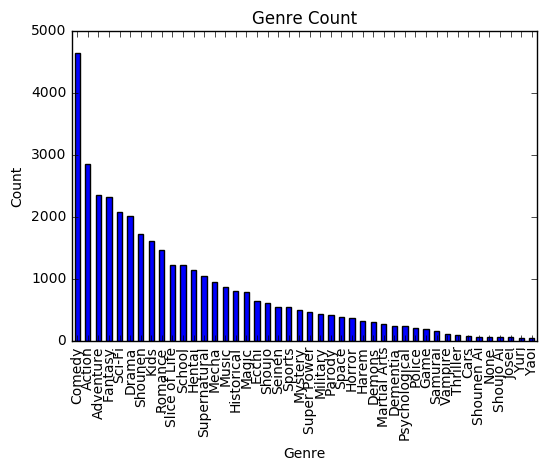

In [3]:
#use collections counter to help generate graph
import collections
genre_counter = collections.Counter(genre_all)
#print genre_counter

enres = pd.DataFrame.from_dict(genre_counter, orient='index').rename(columns={'index':'genre', 0:'count'})
#print enres

my_plot = enres.sort_values(by='count',ascending=False).plot(kind='bar',legend=None,title="Genre Count")
my_plot.set_xlabel("Genre")
my_plot.set_ylabel("Count")

In [4]:
#helper functions

#add genre columns to a dataframe
def add_genre_cols(df, genre):
    for x in genre:
        df[x] = pd.Series(0, index=df.index)
    return df

#fill genre columns using data frame anime.csv
def populate_genre(df):
    columns = list(df)
    for anime_id in df['anime_id']:
        p = anime_data[anime_data['anime_id'] == anime_id].index.tolist()[0]
        s = df[df['anime_id'] == anime_id].index.tolist()[0]
        genre_list = anime_data.iloc[p]['genre']
        for genre_name in genre_list:
            for column_name in columns:
                if genre_name == column_name:
                    df.set_value(s, column_name, 1)
    return df

#transform rating data into 'Like' or 'Dislike' based on chosen threshold
def classify_ratings(df, threshold):
    df_index_list = df.index.tolist()    
    for i in range(0,len(df['rating'])):
        df_index = df_index_list[i]
        if df.iloc[i]['rating'] != -1:
            if df.iloc[i]['rating'] > threshold:
                df.set_value(df_index, 'rating', 1)
            else:
                df.set_value(df_index, 'rating', 0)
    return df

In [5]:
#a function to create a unique dataframe for a given user
def create_user_df(user, genre):
    df_user_frame = rating_data.loc[rating_data['user_id'] == user].copy()
    
    df_user_frame = add_genre_cols(df_user_frame, genre)
    
    df_user_frame = populate_genre(df_user_frame)
                    
    df_user_frame = classify_ratings(df_user_frame, 7)
    
    return df_user_frame

In [6]:
#prepare recommendation dataframe (all anime's not in user's list)
def create_recommendation_df(user_df, genre):
    user_watched = user_df['anime_id'].values.astype(int).tolist()
    rec_df = anime_data[~anime_data['anime_id'].isin(user_watched)][['anime_id','name']]
    
    rec_df = add_genre_cols(rec_df, genre)
    
    return rec_df

#provide a list of X recommendations based on learning
def get_recommendations(user_df, clf, genre, num_to_show):
    rec_df = create_recommendation_df(user_df, genre)
    
    feature_cols = list(rec_df.columns[2:])
    x_guess = rec_df[feature_cols]
    y_pred = clf.predict(x_guess)
    
    like_list = []
    for i in range(0, len(y_pred)):
        if y_pred[i] == 1:
            name = rec_df.iloc[i]['name']
            like_list.append(name)
    
    rand_smpl = [like_list[i] for i in sorted(random.sample(xrange(len(like_list)), num_to_show))]
    return rand_smpl

In [7]:
#Example with user = 3
user_df = create_user_df(3,unique_genres)
print user_df.head(), '\n', user_df.shape

     user_id  anime_id  rating  Action  Adventure  Cars  Comedy  Dementia  \
156        3        20       1       1          0     0       1         0   
157        3       154       0       1          1     0       1         0   
158        3       170       1       0          0     0       1         0   
159        3       199       1       0          1     0       0         0   
160        3       225       1       1          1     0       1         0   

     Demons  Drama  ...   Shounen Ai  Slice of Life  Space  Sports  \
156       0      0  ...            0              0      0       0   
157       0      1  ...            0              0      0       0   
158       0      1  ...            0              0      0       1   
159       0      1  ...            0              0      0       0   
160       0      0  ...            0              0      0       0   

     Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
156            1             0         0        0   

In [8]:
#identify features and target
feature_cols = list(user_df.columns[3:])
target_col = user_df.columns[2]
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

Feature columns:
['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'None', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri']

Target column: rating


In [9]:
#remove unknown data
pred_df = user_df[user_df['rating'] != -1].copy()
print pred_df.head(), '\n', pred_df.shape

     user_id  anime_id  rating  Action  Adventure  Cars  Comedy  Dementia  \
156        3        20       1       1          0     0       1         0   
157        3       154       0       1          1     0       1         0   
158        3       170       1       0          0     0       1         0   
159        3       199       1       0          1     0       0         0   
160        3       225       1       1          1     0       1         0   

     Demons  Drama  ...   Shounen Ai  Slice of Life  Space  Sports  \
156       0      0  ...            0              0      0       0   
157       0      1  ...            0              0      0       0   
158       0      1  ...            0              0      0       1   
159       0      1  ...            0              0      0       0   
160       0      0  ...            0              0      0       0   

     Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
156            1             0         0        0   

In [10]:
#import classifier libraries and f1 scoring metric
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score

In [11]:
#split the data into training and testing sets
X_all = pred_df[feature_cols]
Y_all = pred_df[target_col]

x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, test_size = .25, random_state = 0)

In [12]:
#Gaussian Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(x_train, y_train)

y_pred = clf_gnb.predict(x_test)
print f1_score(y_test, y_pred)

0.625


In [13]:
#Decision Tree
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(x_train,y_train)

y_pred = clf_dt.predict(x_test)
print f1_score(y_test, y_pred)

0.526315789474


In [14]:
#Support Vector Machine
clf_svm = SVC(random_state = 0)
clf_svm.fit(x_train,y_train)

y_pred = clf_svm.predict(x_test)
print f1_score(y_test, y_pred)

0.428571428571


In [15]:
#XGBoost Trees
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(x_train,y_train)

y_pred = clf_xgb.predict(x_test)
print f1_score(y_test, y_pred)

0.857142857143


In [16]:
#optimization of parameters
from sklearn.grid_search import GridSearchCV

#define a dict of parameters and potential values to try
param_tree = {'criterion': ('gini', 'entropy'), 
              'splitter': ('best','random'),
              'max_features': (2,10,20,'auto', None),
              'min_samples_split': (1,2,3,4)
             }

param_svm = {'C': (.1,1,10,100),
             'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
             'gamma': ('auto', .1, 1,2,3,4,5, 10)
            }

param_xgb = {'max_depth': (2,3,4,5,7,9),
             'learning_rate': (.08,.09,.1,.2,.3,.4,.5),
             'n_estimators': (1,10,15,16,18,20,40,60,100)
            }

In [17]:
#gridsearch for decision tree
gs_clf_tree = GridSearchCV(clf_dt,param_tree,scoring='f1')
gs_clf_tree.fit(x_train,y_train)
print gs_clf_tree.best_params_

{'max_features': 2, 'min_samples_split': 1, 'criterion': 'entropy', 'splitter': 'best'}


In [18]:
clf_dt_op = DecisionTreeClassifier(criterion='entropy', min_samples_split=1, max_features=2, random_state=0)
clf_dt_op.fit(x_train,y_train)

y_pred = clf_dt_op.predict(x_test)
print f1_score(y_test, y_pred)

0.588235294118


In [19]:
#gridsearch for support vector machine
gs_clf_svm = GridSearchCV(clf_svm,param_svm,scoring='f1')
gs_clf_svm.fit(x_train,y_train)
print gs_clf_svm.best_params_

D:\Anaconda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'kernel': 'sigmoid', 'C': 1, 'gamma': 1}


In [20]:
clf_svm_op = SVC(kernel='sigmoid', gamma= 1, random_state = 0)
clf_svm_op.fit(x_train,y_train)

y_pred = clf_svm_op.predict(x_test)
print f1_score(y_test, y_pred)

0.47619047619


In [21]:
#gridsearch for XGBoost Trees
gs_clf_xgb = GridSearchCV(clf_xgb,param_xgb,scoring='f1')
gs_clf_xgb.fit(x_train,y_train)
print gs_clf_xgb.best_params_

{'n_estimators': 15, 'learning_rate': 0.08, 'max_depth': 4}


In [22]:
clf_xgb_op = xgb.XGBClassifier(max_depth=4,learning_rate=0.08,n_estimators=15)
clf_xgb_op.fit(x_train,y_train)

y_pred = clf_xgb_op.predict(x_test)
print f1_score(y_test, y_pred)

0.8


In [23]:
recommendations = get_recommendations(user_df, clf_xgb, unique_genres, 10)
print recommendations

['Beelzebub Specials', 'Ore no Imouto ga Konnani Kawaii Wake ga Nai: SD Chara ni Yoru Character Commentary', 'Fushigi Yuugi: Eikouden', 'Boku no Chikyuu wo Mamotte: Kiniro no Toki Nasarete', 'Dr. Slump Movie 09: Arale-chan N-cha!! Wakuwaku Hot no Natsuyasumi', 'Kurumiwari Ningyou', 'Under the Dog: Anthea-chan', 'C.L.A.Y.', 'Straw-saurus Neo', 'Hitoriga The Animation']


In [24]:
for x in recommendations:
    genre = anime_data.loc[anime_data['name'] == x, 'genre']
    print x, ' ', genre

Beelzebub Specials   1777    [Action, Comedy, Demons, School, Shounen, Supe...
Name: genre, dtype: object
Ore no Imouto ga Konnani Kawaii Wake ga Nai: SD Chara ni Yoru Character Commentary   2804    [Comedy]
Name: genre, dtype: object
Fushigi Yuugi: Eikouden   3409    [Adventure, Drama, Fantasy, Romance, Shoujo]
Name: genre, dtype: object
Boku no Chikyuu wo Mamotte: Kiniro no Toki Nasarete   3893    [Drama, Music, Romance, Sci-Fi, Shoujo]
Name: genre, dtype: object
Dr. Slump Movie 09: Arale-chan N-cha!! Wakuwaku Hot no Natsuyasumi   5137    [Comedy, Sci-Fi, Shounen]
Name: genre, dtype: object
Kurumiwari Ningyou   5869    [Drama, Fantasy, Romance]
Name: genre, dtype: object
Under the Dog: Anthea-chan   7926    [Action, Comedy, Parody]
Name: genre, dtype: object
C.L.A.Y.   8021    [Horror]
Name: genre, dtype: object
Straw-saurus Neo   10411    [Adventure, Fantasy, Kids, Sci-Fi]
Name: genre, dtype: object
Hitoriga The Animation   11470    [Hentai]
Name: genre, dtype: object
